<a href="https://colab.research.google.com/github/JayBlaine/WSBAI/blob/main/WSBAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Regression model

### **DO NOT RUNTIME->RUN ALL, WILL CRASH RUNTIME AT LIVE PRAW SCRAPE DUE TO MEMORY CONSRTAINTS, MUST RUN INDIVIDUALLY**

Code section for reading GMEs stock data


In [1]:
#!pip install asyncpraw
#!pip install asyncio

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as web
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import csv, math, os
# Linear Regression model
from __future__ import absolute_import, division, print_function, unicode_literals
from IPython.display import clear_output
from six.moves import urllib
import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf
# Reddit data scrape
import asyncpraw
import asyncio
import nest_asyncio
# Make numpy values easier to read.
# Other model
np.set_printoptions(precision=3, suppress=True)
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

def main():
    stonk = "GME"
    start = dt.datetime(2021, 1, 1)
    end = dt.datetime.today()

    data = web.DataReader(stonk,'stooq', start, end).reset_index()
    data.drop('High', 1, inplace=True)
    data.drop('Low', 1, inplace=True)

    data = data.to_csv(r'./stonkdata.csv', index=False, header=True)
    
if __name__ == '__main__':
    main()

In [2]:
# WSB data set read
# DO NOT RUN AFTER LIVE SCRAPE STARTS
# SERIOUSLY, YOU WILL RUIN DATASET ONCE LIVE SCRAPING BEGINS

def gmeChecker(title, body):
  gmeKeys = ['gme', 'gamestop', 'dfv', 'deep fucking value', 'citadel', 'ken griffin', 'keith', 'gill', 'roaring kitty', 'if he\'s in', 'if hes in']
  title = title.strip().lower()
  body = body.strip().lower()
  for key in gmeKeys:
    # body and title
    if key in title or key in body:
      return True
  return False

def dateChecker(date1):
  dtTemp = dt.datetime.strptime(date1, '%Y-%m-%d %H:%M:%S')
  actDate = dtTemp.date()
  return actDate

dateStockData = []
dateStockData = pd.read_csv('./stonkdata.csv', usecols=['Date', 'Open', 'Close'])
newD = pd.DataFrame(dateStockData)
newD = newD.iloc[::-1]
lineCount = len(dateStockData)

# date, reddit total posts, gme total posts, ratio of gme to total, 
# avg score of reddit posts, average score of gme posts, avg comments total, avg comments gme
byDate = {}

# https://www.kaggle.com/gpreda/reddit-wallstreetsbets-posts
wsbDataframe = pd.read_csv("reddit_wsb.csv")

with open('reddit_wsb.csv') as csv_file: 
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
      if line_count > 1:
        tempTitle = row[0]
        tempScore = row[1]
        tempCommNum = row[4]
        tempBody = row[6]
        tempDate = row[7]
        tempPass = [tempTitle, tempScore, tempCommNum, tempBody, tempDate]
        date1 = dateChecker(tempDate)

        if date1 not in byDate.keys():
          byDate[date1] = []
          byDate[date1].append(tempPass)
        else:
          byDate[date1].append(tempPass)
      line_count+=1

redditPrelim = []

for key in byDate.keys():
  if key.year < 2021: #Gets rid of rogue row at 9/2020
      continue
  i=0
  gmeCnt = 0
  gmeCommTotal = 0
  gmeUpTotal = 0
  while i < len(byDate[key]):
    gmeCheck = gmeChecker(byDate[key][i][0], byDate[key][i][3])
    if gmeCheck:
      gmeCnt+=1
      gmeCommTotal+=int(byDate[key][i][2])
      gmeUpTotal+=int(byDate[key][i][1])
    i+=1
  if i > 0 and gmeCnt > 0: # both posts and gme posts
    redditPrelim.append([key, i, gmeCnt, gmeCnt/i, gmeUpTotal/gmeCnt, gmeCommTotal/gmeCnt])
  elif i > 0: # no gme posts
    redditPrelim.append([key, i, gmeCnt, gmeCnt/i, 0, 0])
  else: # no posts
    continue

# print(redditPrelim)
columns = dateStockData.filter(["Date"]).values
with open('wsb_clean.csv', mode='w') as write_file:
    writer = csv.writer(write_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    i=0
    date=0
    #TODO
    writer.writerow(['Date', 'open', 'close', 'total posts', 'GME count', '% GME', 'avg GME upvotes', 'avg GME comments'])
    while i < len(redditPrelim):
      if str(redditPrelim[i][0]) in columns:
        writer.writerow([redditPrelim[i][0], dateStockData['Open'][date], dateStockData['Close'][date], redditPrelim[i][1], 
                         redditPrelim[i][2], redditPrelim[i][3], redditPrelim[i][4], redditPrelim[i][5]])
        date+=1
      i+=1



In [15]:
# REDDIT DATA SCRAPE

async def reddo(posts):
  reddit = asyncpraw.Reddit(client_id='ORNE1J4ncT_tGg', client_secret= 'sa-2SPPkOY-w_kMIBSeAostYFg804Q', user_agent='WSBAI:Python/urllib:v0.0.1 (by u/WSBAI_00123)', 
                            username="WSBAI_00123", password="lint$h@d0w,./")
  wsb_sub = await reddit.subreddit('WallStreetBets')
  
  i = 0
  print(reddit.read_only)

  async for submission in wsb_sub.new(limit=600):
    posts.append([submission.title, submission.score, submission.num_comments, submission.selftext, submission.created])
  print(len(posts))
  
  await reddit.close()
  return posts

posts = []
nest_asyncio.apply()
loop = asyncio.get_event_loop() 
posts = loop.run_until_complete(reddo(posts))
#print(posts)

test_eval = []
i=0
gmeCnt = 0
gmeCommTotal = 0
gmeUpTotal = 0
while i < len(posts):
  gmeCheck = gmeChecker(posts[i][0], posts[i][3])
  if gmeCheck:
    gmeCnt+=1
    gmeCommTotal+=int(posts[i][2])
    gmeUpTotal+=int(posts[i][1])
  i+=1
if i > 0 and gmeCnt > 0: # both posts and gme posts
  test_eval = [dt.date.today(), dateStockData['Open'][0], dateStockData['Close'][0], i, gmeCnt, gmeCnt/i, gmeUpTotal/gmeCnt, gmeCommTotal/gmeCnt]
elif i > 0: # no gme posts
  test_eval= [dt.date.today(), dateStockData['Open'][0], dateStockData['Close'][0], i, gmeCnt, gmeCnt/i, 0, 0]
test_eval = pd.DataFrame([test_eval],columns=['Date', 'open', 'close', 'total posts', 'GME count', '% GME', 'avg GME upvotes', 'avg GME comments'])
test_eval.to_csv('eval.csv')

print(test_eval)


False
564
         Date   open   close  ...     % GME  avg GME upvotes  avg GME comments
0  2021-04-23  159.1  151.17  ...  0.124113      4902.628571       1653.114286

[1 rows x 8 columns]


Break

{'average_loss': 8.775918, 'label/mean': 151.17, 'loss': 8.775918, 'prediction/mean': 154.13242, 'global_step': 200}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp787dx5_s/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[{'predictions': array([154.132], dtype=float32)}]
154.13242


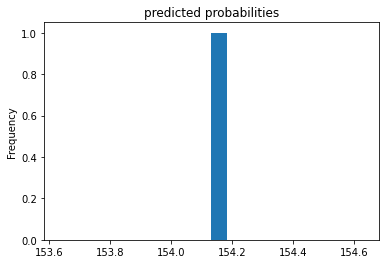

In [16]:

fullFile = pd.read_csv('wsb_clean.csv')
testDataSize = len(fullFile)-1
# Load dataset.
dftrain = fullFile.head(testDataSize) # training data
dfeval = pd.read_csv('eval.csv') # testing data


dftrain.pop('Date')
dfeval.pop('Date')
y_train = dftrain.pop('close')
y_eval = dfeval.pop('close')


dataCol = ['open', 'total posts', 'GME count', '% GME', 'avg GME upvotes', 'avg GME comments']
feature_col = []
for feature in dataCol:
  feature_col.append(tf.feature_column.numeric_column(feature, dtype=tf.float32))


def make_input_fn(data, label, epochs=50, shuffle=True, batch=16):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data), label))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch).repeat(epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use


train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, epochs=1, shuffle=False)


linear_est = tf.estimator.LinearRegressor(feature_columns=feature_col)
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on testing data


clear_output()  # clears consoke output
print(result)  # the result variable is simply a dict of stats about our model


pred_dicts = list(linear_est.predict(eval_input_fn))
print(pred_dicts)


prediction = pred_dicts[0]['predictions'][0]
print(prediction)


probs = pd.Series([pred['predictions'][0] for pred in pred_dicts]) # DELETE WHEN GRAPH IS DONE
probs.plot(kind='hist', bins=20, title='predicted probabilities')

Creating Guess



In [5]:
daysToPredict = 62
predictionLayers = 128

# Open the stock data file
stonkData = pd.read_csv('./stonkdata.csv') # format = Date, Open, Close, Volume

# Reading only the closing prices
# stonkWithDate = stonkData.filter(['Close'], ['Date'])
stonkPrices = (stonkData.filter(['Close'])).values
dataLength = len(stonkPrices)

# If we only want to train half of the data
#halfOfData = math.ceil(len(stonkPrices) * 0.5)

# Scaling the data / Takes in the stock data and makes it into a number between 0 and 1
dataScaler = MinMaxScaler(feature_range=(0,1))
scaledData = dataScaler.fit_transform(stonkPrices).reshape(-1,1)

# Spliting up the data for x and y training
x_train = []
y_train = []

# Amount we wanted trained using the length of our data
for x in range(daysToPredict, dataLength):
  x_train.append(scaledData[x - daysToPredict:x, 0])
  y_train.append(scaledData[x, 0])
  if x <= daysToPredict:
    print(f"X data-----------------\n{x_train}\nY data-----------------\n{y_train}")

x_train = np.array(x_train)
y_train = np.array(x_train)

# x_train = np.reshape(x_train, dataLength, daysToPredict, 1)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# print(x_train.shape)
# print(y_train.shape)


X data-----------------
[array([0.405, 0.428, 0.428, 0.445, 0.416, 0.421, 0.452, 0.375, 0.375,
       0.427, 0.463, 0.487, 0.506, 0.514, 0.527, 0.523, 0.537, 0.497,
       0.496, 0.504, 0.312, 0.498, 0.537, 0.554, 0.559, 0.583, 0.578,
       0.614, 0.749, 0.735, 0.75 , 0.695, 0.537, 0.365, 0.349, 0.324,
       0.306, 0.312, 0.256, 0.277, 0.225, 0.084, 0.087, 0.071, 0.071,
       0.087, 0.098, 0.106, 0.102, 0.103, 0.1  , 0.129, 0.141, 0.11 ,
       0.228, 0.22 , 0.629, 0.932, 0.534, 1.   , 0.396, 0.18 ])]
Y data-----------------
[0.14461333494822265]


Creating the training the model

In [6]:
# Building the model
model = Sequential()
model.add(LSTM(units=predictionLayers, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# Dropout randomly inputs 0s to help against overfitting (at a rate of 0.2)
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=30, batch_size=8)

Epoch 1/30
2/2 [==============================] - 3s 81ms/step - loss: 0.1744
Epoch 2/30
2/2 [==============================] - 0s 89ms/step - loss: 0.0752
Epoch 3/30
2/2 [==============================] - 0s 73ms/step - loss: 0.0798
Epoch 4/30
2/2 [==============================] - 0s 69ms/step - loss: 0.0638
Epoch 5/30
2/2 [==============================] - 0s 71ms/step - loss: 0.0641
Epoch 6/30
2/2 [==============================] - 0s 75ms/step - loss: 0.0657
Epoch 7/30
2/2 [==============================] - 0s 76ms/step - loss: 0.0655
Epoch 8/30
2/2 [==============================] - 0s 75ms/step - loss: 0.0626
Epoch 9/30
2/2 [==============================] - 0s 78ms/step - loss: 0.0597
Epoch 10/30
2/2 [==============================] - 0s 78ms/step - loss: 0.0625
Epoch 11/30
2/2 [==============================] - 0s 80ms/step - loss: 0.0597
Epoch 12/30
2/2 [==============================] - 0s 79ms/step - loss: 0.0581
Epoch 13/30
2/2 [==============================] - 0s 81ms/st

How close the data got

In [7]:
test_data = pd.read_csv("./stonkdata.csv")

firstPart = test_data.iloc[0:10]['Close'].values

# actual_prices = test_data['Close'].values

print(firstPart)

[151.17 158.51 158.53 164.37 154.69 156.44 166.53 140.99 141.09 158.36]


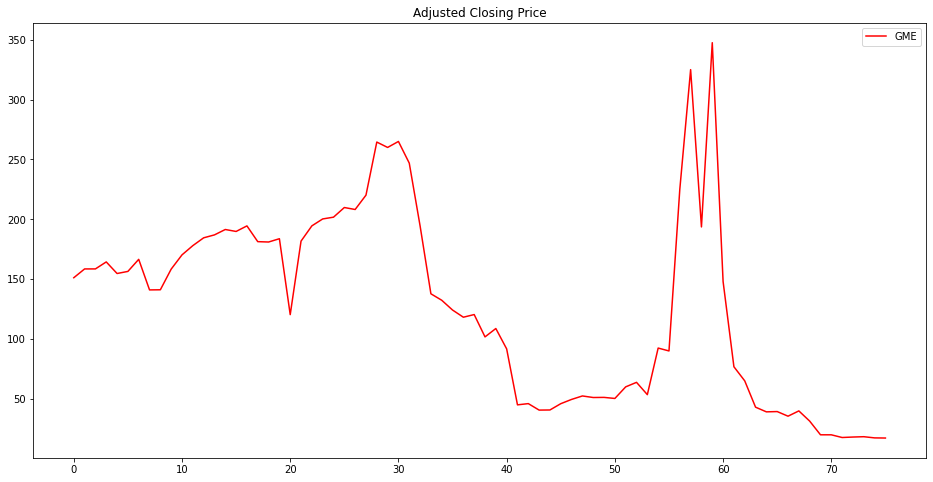

In [8]:
graphStonks = pd.read_csv("./stonkdata.csv")

graphStonks.head()
graphStonks['Close'].plot(label='GME', figsize=(16, 8), title='Adjusted Closing Price', color='red')
plt.legend();